This is the cutdown companion Jupyter Notebook of Chapter 5, Variational Quantum Eigensolver (VQE) Algorithm, of the book titled:
"Quantum Chemistry and Computing for the Curious: Illustrated with Python and Qiskit® code" and with ISBN-13: 978-1803243900.
Copyright © 2022, Keeper L. Sharkey and Alain Chancé.

The following MIT license only applies to the code, and not to the text and images. The authors are not granting a license to replicate or reuse the text and images in the companion Jupyter notebook.

# MIT License

Copyright (c) 2022 Packt

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.


# 5. Variational Quantum Eigensolver (VQE) Algorithm

# Technical requirements

# Summary of updates V2
## Purpose
This Jupyter notebook has been adapted to work with Qiskit Nature v0.5 and the new Qiskit Runtime primitives. 

Please refer to the following documentation:

Electronic Structure Problems with v0.5, https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html

Leveraging Qiskit Runtime
https://qiskit.org/documentation/nature/tutorials/07_leveraging_qiskit_runtime.html

## New install command
Install qiskit.utils with the following command (V2):
```
pip install qiskit.utils
```
## Updates in import statements
Previously
```
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter

from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.circuit.library.initial_states import HartreeFock
from qiskit_nature.circuit.library.ansatzes import UCCSD
```
New
```
# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import QubitConverter
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer
```

Previously
```
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver, NumPyMinimumEigensolverFactory, BOPESSampler
from qiskit.algorithms import NumPyMinimumEigensolver, VQE, HamiltonianPhaseEstimation, PhaseEstimation
```

New
```
# https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html
from qiskit.algorithms import HamiltonianPhaseEstimation, PhaseEstimation

# https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html
from qiskit.primitives import Estimator, Sampler

from qiskit.algorithms.optimizers import SLSQP, SPSA, QNSPSA
from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit_nature.second_q.circuit.library import UCCSD

from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
```

### The Qiskit Nature property framework is now longer used 
The following import statement has been removed:
```
from qiskit_nature.properties import Property, GroupedProperty
```


## Updates in code

### New function bopes() for sampling the potential energy surface
The BOPESSampler() previously used will soon be removed, https://github.com/Qiskit/qiskit-nature/issues/750 .
The MoleculeInfo has become a pure data container and no longer supports degrees of freedom.

The new function bopes() manages the process of varying the geometry of the molecule and repeatedly calls the solve_ground_state() function. Atoms in the atom pair specified in the info-dict dictionary must have their coordinates in the same line or in the same plane. The perturbation is applied to the first atom in the atom_pair.
```
def bopes(info_dict, mapper, num_electrons, num_spatial_orbitals, two_qubit_reduction, z2symmetry_reduction,
          name_solver, perturbation_steps, qubit_converter, solver, show=True):
```

### Updates to leverage Qiskit Runtime primitives

Previously
```
vqe_tl_solver = VQE(ansatz = tl_circuit,
                     quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector')))
```
New
```
estimator = Estimator()
optimizer = SPSA(maxiter=100)
vqe_tl_solver = VQE(estimator, tl_circuit, optimizer)
```

Previously
```
vqe_ucc_solver = VQEUCCFactory(quantum_instance, ansatz = tl_circuit)
```
New
```
vqe_ucc_solver = VQEUCCFactory(Estimator(), UCCSD(), SLSQP())
```

Previously
```
qnspsa_loss = []
ansatz = tl_circuit
fidelity = QNSPSA.get_fidelity(ansatz, quantum_instance, expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=200, learning_rate=0.01, perturbation=0.7, callback=qnspsa_callback)
```
New
#### The Quantum Natural SPSA (QN-SPSA) optimizer
https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.QNSPSA.html
```
qnspsa_loss = []
ansatz = tl_circuit
sampler = Sampler()
fidelity = QNSPSA.get_fidelity(ansatz, sampler)
qnspsa = QNSPSA(fidelity, maxiter=200, learning_rate=0.01, perturbation=0.7, callback=qnspsa_callback)
```

### Updates pertaining to the new MoleculeInfo data structure
The MoleculeInfo has become a pure data container and no longer supports degrees of freedom. This version uses a new info_dict dictionary to set up both the MoleculeInfo and the PySCF molecule data structure.

The info_dict dictionary contains the following keys:
- 'atoms', a list of atoms names, e.g. "Li", "H".
- 'coords', Cartesian coordinates $(x, y, z)$ of the atom’s position in units of angstroms., e.g. (0.0, 0.0, 0.0), (0.0, 0.0, 1.5474)
- 'charge', integer, the electric charge on the molecule.
- 'multiplicity', integer, the multiplicity $2S+1$ of the molecule, where $S$ is the total spin angular momentum which is determined by the number of unpaired electrons in the molecule, that is the number of electrons that occupy a molecular orbital singly, not with another electron.
- 'atom_pair', the pair of atoms used by bopes() to compute and plot the BOPES of the molecule. The numbers refer to the index of the atom in the atoms list. They must have their Cartesian coordinates in the same line or in the same plane. The perturbation is applied to the first atom in the atom_pair.

Previously
```
run_PySCF(molecule, pyqmc=True, show=True):
```
New
```
run_PySCF(info_dict, pyqmc=True, show=True):
```

Previously
```
H2_molecule = Molecule(geometry=[['H', [0., 0., 0.]],['H', [0., 0., 0.735]]],charge=0, multiplicity=1)
```
New
```
H2_atoms = ["H", "H"]
H2_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 0.735)]
H2_charge = 0
H2_multiplicity = 1
H2_atom_pair=(1, 0)
H2_info_dict={'atoms':H2_atoms, 'coords':H2_coords, 'charge':H2_charge, 'multiplicity':H2_multiplicity, 'atom_pair':H2_atom_pair}

H2_moleculeinfo = MoleculeInfo(H2_atoms, H2_coords, charge=H2_charge, multiplicity=H2_multiplicity)
```

Previously
```
LiH_molecule = Molecule(geometry=[['Li', [0., 0., 0.]], ['H', [0., 0., 1.5474]]], charge=0, multiplicity=1)
```

New
```
LiH_atoms = ["Li", "H"]
LiH_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 1.5474)]
LiH_charge = 0
LiH_multiplicity = 1
LiH_atom_pair=(1,0)
LiH_info_dict={'atoms':LiH_atoms, 'coords':LiH_coords, 'charge':LiH_charge, 'multiplicity':LiH_multiplicity, 'atom_pair':LiH_atom_pair}

LiH_moleculeinfo = MoleculeInfo(LiH_atoms, LiH_coords, charge=LiH_charge, multiplicity=LiH_multiplicity)
```

Previously
```
macromolecule = Molecule(geometry=
   [['O', [1.1280, 0.2091, 0.0000]],
   ['N', [-1.1878, 0.1791, 0.0000]],
   ['C', [0.0598, -0.3882, 0.0000]],
   ['H', [-1.3085, 1.1864, 0.0001]],
   ['H', [-2.0305, -0.3861, -0.0001]],
   ['H', [-0.0014, -1.4883, -0.0001]],
   ['C', [-0.1805, 1.3955, 0.0000]]],
   charge=0, multiplicity=1,
   degrees_of_freedom=[specific_molecular_variation])
```
New
```
M_atoms = ["O", "N","C","H","H","H","C"]
M_coords = [(1.1280, 0.2091, 0.0000), 
                    (-1.1878, 0.1791, 0.0000),
                    (0.0598, -0.3882, 0.0000),
                    (-1.3085, 1.1864, 0.0001),
                    (-2.0305, -0.3861, -0.0001),
                    (-0.0014, -1.4883, -0.0001),
                    (-0.1805, 1.3955, 0.0000)]
M_charge = 0
M_multiplicity = 1
M_atom_pair=(6, 1)
M_info_dict={'atoms':M_atoms, 'coords':M_coords, 'charge':M_charge, 'multiplicity':M_multiplicity, 'atom_pair':M_atom_pair}

macromoleculeinfo = MoleculeInfo(M_atoms, M_coords, charge=M_charge, multiplicity=M_multiplicity)
```

### Updates pertaining to the get_particle_number() function
Previously
```
def get_particle_number(problem, show=True):
  particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
  num_particles = (particle_number.num_alpha, particle_number.num_beta)
  num_spin_orbitals = particle_number.num_spin_orbitals
  if show:
    print("Number of alpha electrons: {}".format(particle_number.num_alpha))
    print("Number of beta electrons: {}".format(particle_number.num_beta))
    print("Number of spin orbitals: {}".format(num_spin_orbitals))
  return particle_number
```
New
```
def get_particle_number(problem, show=True):
  
  # https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.problems.ElectronicStructureProblem.num_spin_orbitals.html
  num_spin_orbitals = problem.num_spin_orbitals
  num_particles = problem.num_particles
  
  if show:
    print("Number of particles: {}".format(num_particles))
    print("Number of spin orbitals: {}".format(num_spin_orbitals))
    
  return num_particles, num_spin_orbitals
```
### Updates pertaining to the fermion_to_qubit() function
Now second_q_op is used as a replacement for second_q_op[0]

Previously
```
def fermion_to_qubit(f_op, second_q_op, mapper, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
  if show:
    print("Qubit Hamiltonian operator")
  dmap = {"Jordan-Wigner": JordanWignerMapper(), "Parity": ParityMapper(), "Bravyi-Kitaev": BravyiKitaevMapper()}
  qubit_op = None
  qubit_converter = None
  for k, v in dmap.items():
    if k == mapper:
      if show:
        print("{} transformation ". format(mapper))
      qubit_converter = QubitConverter(v, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction)
      if two_qubit_reduction:
        qubit_op = qubit_converter.convert(second_q_op[0], num_particles=f_op.num_particles)
      else:
        qubit_op = qubit_converter.convert(second_q_op[0])
      n_items = len(qubit_op)
      if show:
        print("Number of items in the Pauli list:", n_items)
        if n_items <= truncate:
          print(qubit_op)
        else:
          print(qubit_op[0:truncate])
  return qubit_op, qubit_converter
```
New
```
def fermion_to_qubit(problem, second_q_op, mapper, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
# https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.QubitConverter.html#qubitconverter
  if show:
    print("Qubit Hamiltonian operator")
  dmap = {"Jordan-Wigner": JordanWignerMapper(), "Parity": ParityMapper(), "Bravyi-Kitaev": BravyiKitaevMapper()}
  qubit_op = None
  qubit_converter = None
  for k, v in dmap.items():
    if k == mapper:
      if show:
        print("{} transformation ". format(mapper))
      qubit_converter = QubitConverter(v, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction)
      # QubitConverter.convert
      # https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.QubitConverter.convert.html
      if two_qubit_reduction:
        qubit_op = qubit_converter.convert(second_q_op, num_particles=problem.num_particles)
      else:
        qubit_op = qubit_converter.convert(second_q_op)
      n_items = len(qubit_op)
      if show:
        print("Number of items in the Pauli list:", n_items)
        if n_items <= truncate:
          print(qubit_op)
        else:
          print(qubit_op[0:truncate])
  return qubit_op, qubit_converter
```

### Updates pertaining to the solve_ground_state() function
The molecule parameter has been replaced by the new info_dict dictionary.

Previously
```
def solve_ground_state(
    molecule,
    mapper ="Parity",
    num_electrons=None,
    num_molecular_orbitals=None,
    transformers=None,
    two_qubit_reduction=False,
    z2symmetry_reduction = "Auto",
    name_solver='NumPy exact solver',
    solver=NumPyMinimumEigensolver(),
    plot_bopes=False,
    perturbation_steps=np.linspace(-1, 1, 3),
    pyqmc=True,
    n_ancillae=3, 
    num_time_slices=1,
    loss=[],
    label=None,
    target=None,
    show=True
):
```
New
```
def solve_ground_state(
    info_dict,
    mapper ="Parity",
    num_electrons=None,
    num_spatial_orbitals=None,
    freeze_core=None, 
    two_qubit_reduction=False,
    z2symmetry_reduction = "Auto",
    name_solver='NumPy exact solver',
    solver=NumPyMinimumEigensolver(),
    plot_bopes=False,
    perturbation_steps=np.linspace(-1, 1, 3),
    pyqmc=True,
    n_ancillae=3, 
    num_time_slices=1,
    loss=[],
    label=None,
    target=None,
    show=True
):
```

All calls to the solve_ground_state() function have been updated to use the new info_dict dictionary. Examples follow:

Previously
```
H2_fermionic_hamiltonian, H2_particle_number, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
                  solve_ground_state(hydrogen_molecule, mapper ="Parity",
                   two_qubit_reduction=True, z2symmetry_reduction=None, 
                   name_solver = 'NumPy exact solver', solver = numpy_solver)
```
New
```
H2_fermionic_hamiltonian, H2_num_particles, H2_num_spin_orbitals, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
                  solve_ground_state(H2_info_dict, mapper ="Parity",
                   two_qubit_reduction=True, z2symmetry_reduction=None, 
                   name_solver = 'Heuristic ansatz, the Two-Local circuit with SLSQP',solver = vqe_tl_solver)
```

Previously
```
perturbation_steps = np.linspace(-0.8, 0.8, 10) # 10 equally spaced points from -0.8 to 0.8, inclusive.
LiH_stretchable_fermionic_hamiltonian, LiH_stretchable_particle_number, LiH_stretchable_qubit_op, LiH_stretchable_qubit_converter, LiH_stretchable_ground_state = \
                  solve_ground_state(LiH_molecule_stretchable, mapper ="Parity",
                  transformers=[FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3])],
                   two_qubit_reduction=True, z2symmetry_reduction="auto", 
                   name_solver='NumPy exact solver', solver=numpy_solver,
                   plot_bopes=True, perturbation_steps=perturbation_steps)
```
New
```
perturbation_steps = np.linspace(-0.8, 0.8, 10) # 10 equally spaced points from -0.8 to 0.8, inclusive.
LiH_s_fermionic_hamiltonian, LiH_s_num_particles, LiH_s_num_spin_orbitals, LiH_s_qubit_op, LiH_s_qubit_converter, LiH_s_ground_state = \
                  solve_ground_state(LiH_info_dict, mapper ="Parity",
                  freeze_core=FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3]),
                   two_qubit_reduction=True, z2symmetry_reduction="auto", 
                   name_solver='NumPy exact solver', solver=numpy_solver,
                   plot_bopes=True, perturbation_steps=perturbation_steps)
```

### Varying molecule code no longer used
The following code has been removed:
```
### Varying the hydrogen molecule
We specify the type of molecular variation, Molecule.absolute_stretching as follows:

molecular_variation = Molecule.absolute_stretching

We specify that the first atom of the specified atom pair is moved closer to the second atom. The numbers refer to the index of the atom in the geometric definition list. Here is the code:

We alter the original molecular definition as follows:

H2_molecule_stretchable = Molecule(geometry=
                                 [['H', [0., 0., 0.]], ['H', [0., 0., 0.735]]], charge=0, multiplicity=1,
                                 degrees_of_freedom=[specific_molecular_variation])

```

```
### Varying the lithium hydride molecule

We alter the original molecular definition as follows:

LiH_molecule_stretchable = Molecule(geometry=[['Li', [0., 0., 0.]], ['H', [0., 0., 1.5474]]], charge=0, multiplicity=1,
                                   degrees_of_freedom=[specific_molecular_variation])
```

```
We specify the type of molecular variation, Molecule.absolute_stretching as follows:

molecular_variation = Molecule.absolute_stretching

We specify which atoms the variation applies to. The numbers refer to the index of the atom in the geometric definition list. The Carbon atom is moved closer to the Nitrogen atom:

specific_molecular_variation = apply_variation(molecular_variation, atom_pair=(6, 1))
```


## Installing NumPy, and Qiskit and importing various modules
Install NumPy with the following command:

In [1]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


Install Qiskit with the following command:

In [2]:
pip install qiskit

  Using cached qiskit_terra-0.21.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.7 MB)
  Attempting uninstall: qiskit-terra
    Found existing installation: qiskit-terra 0.22.3
    Uninstalling qiskit-terra-0.22.3:
      Successfully uninstalled qiskit-terra-0.22.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-nature 0.5.1 requires qiskit-terra>=0.22.*, but you have qiskit-terra 0.21.2 which is incompatible.
qiskit-ibm-runtime 0.8.0 requires qiskit-terra>=0.22, but you have qiskit-terra 0.21.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


Install Qiskit visualization support with the following command:

In [3]:
pip install 'qiskit[visualization]'

Note: you may need to restart the kernel to use updated packages.


Install qiskit.utils with the following command (V2):

In [4]:
pip install qiskit.utils

Note: you may need to restart the kernel to use updated packages.


Install Qiskit Nature with the following command:

In [5]:
pip install qiskit-nature

  Using cached qiskit_terra-0.22.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.8 MB)
  Attempting uninstall: qiskit-terra
    Found existing installation: qiskit-terra 0.21.2
    Uninstalling qiskit-terra-0.21.2:
      Successfully uninstalled qiskit-terra-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit 0.38.0 requires qiskit-terra==0.21.2, but you have qiskit-terra 0.22.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


Install PySCF with the following command:

In [6]:
pip install pyscf

Note: you may need to restart the kernel to use updated packages.


Install QuTiP with the following command:

In [7]:
pip install qutip

Note: you may need to restart the kernel to use updated packages.


Install ASE with the following command:

In [8]:
pip install ase

Note: you may need to restart the kernel to use updated packages.


Install PyQMC with the following command:

In [9]:
pip install pyqmc --upgrade

Note: you may need to restart the kernel to use updated packages.


Install h5py with the following command:

In [10]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


Install SciPy with the following command:

In [11]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


Import NumPy with the following command:

In [12]:
import numpy as np

Import Matplotlib, a comprehensive library for creating static, animated, and interactive visualizations in Python with the following command:



In [13]:
import matplotlib.pyplot as plt

Import the required functions and class methods. The array_to_latex function() returns a Latex representation of a complex array with dimension 1 or 2:

In [14]:
from qiskit.visualization import array_to_latex, plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere, plot_state_city
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit import execute, Aer
import qiskit.quantum_info as qi
from qiskit.extensions import Initialize
#from qiskit.providers.aer import extensions  # import aer snapshot instructions

Import Qiskit Nature libraries with the following commands:








In [15]:
from qiskit import Aer
from qiskit_nature.drivers import UnitsType, Molecule

#from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
#from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
#from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
#from qiskit_nature.converters.second_quantization import QubitConverter

# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import QubitConverter
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer, FreezeCoreTransformer

#from qiskit_nature.operators.second_quantization import FermionicOp
#from qiskit_nature.circuit.library.initial_states import HartreeFock
#from qiskit_nature.circuit.library.ansatzes import UCCSD

Import the Qiskit Aer statevector simulator and various algorithms with the following commands:

In [16]:
from qiskit.providers.aer import StatevectorSimulator
from qiskit import Aer
from qiskit.utils import QuantumInstance

#from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver, NumPyMinimumEigensolverFactory, BOPESSampler
#from qiskit.algorithms import NumPyMinimumEigensolver, VQE, HamiltonianPhaseEstimation, PhaseEstimation

from qiskit.algorithms import HamiltonianPhaseEstimation, PhaseEstimation

# https://github.com/Qiskit/qiskit-nature/issues/750
#from qiskit_nature.algorithms import BOPESSampler

# https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html
from qiskit.primitives import Estimator, Sampler

from qiskit.algorithms.optimizers import SLSQP, SPSA, QNSPSA
from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit_nature.second_q.circuit.library import UCCSD

from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver

from qiskit.circuit.library import TwoLocal
from qiskit.opflow import StateFn, PauliExpectation,  CircuitSampler, PauliTrotterEvolution
from functools import partial as apply_variation

Import the PySCF gto and scf libraries with the following command:

In [17]:
from pyscf import gto, scf

Import the PyQMC API library with the following command:

In [18]:
import pyqmc.api as pyq

Import h5py with the following command:



In [19]:
import h5py

Import the ASE libraries, the Atoms object, molecular data, and visualizations with the following commands:

In [20]:
from ase import Atoms
from ase.build import molecule
from ase.visualize import view

Import the math libraries with the following commands:

In [21]:
import cmath
import math

Import Python’s statistical functions provided by the SciPy package with the following command:

In [22]:
import scipy.stats as stats

Import QuTiP with the following command:





In [23]:
import qutip

Import time and datetime with the following command:

In [24]:
import time, datetime

Import pandas and os.path with the following commands:

In [25]:
import pandas as pd
import os.path

# 5.1. Variational method

## 5.1.1. The Ritz variational theorem

## 5.1.2. Variational Monte Carlo methods

In [26]:
def p(x):
  if x < 0:
    y = 0
  else:
    y = np.exp(-x)
  return(y)

In [27]:
n = 10000 # Size of the Markov chain stationary distribution

# Use np.linspace to create an array of n numbers between 0 and n
index = np.linspace(0, n, num=n)
x = np.linspace(0, n, num=n)

x[0] = 3     # Initialize to 3
for i in range(1, n):
  current_x = x[i-1]

  # We add a N(0,1) random number to x
  proposed_x = current_x + stats.norm.rvs(loc=0, scale=1, size=1, random_state=None)

  A = min(1, p(proposed_x)/p(current_x))

  r = np.random.uniform(0,1) # Generate a uniform random number in [0, 1]

  if r < A:
    x[i] = proposed_x       # Accept move with probabilty min(1,A)
  else:
    x[i] = current_x        # Otherwise "reject" move, and stay where we are

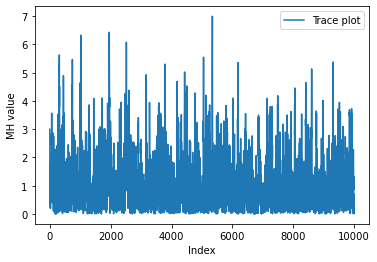

In [28]:
plt.plot(index, x, label="Trace plot")
plt.xlabel('Index')
plt.ylabel('MH value')
plt.legend()
plt.show()

Figure 5.2 – Plot of the locations visited by the Markov chain  x

In [29]:
q25, q75 = np.percentile(x, [25, 75])
bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
bins = round((x.max() - x.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)

Freedman–Diaconis number of bins: 67


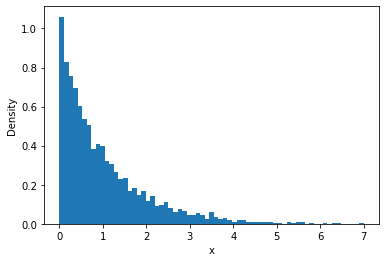

In [30]:
plt.hist(x, density=True, bins=bins)
plt.ylabel('Density')
plt.xlabel('x');

Figure 5.3 – Histogram of the Markov chain  x

In [31]:
def run_PySCF(info_dict, pyqmc=True, show=True):
  # Reset the files
  for fname in ['mf.hdf5','optimized_wf.hdf5','vmc_data.hdf5','dmc.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
  
  atoms = info_dict['atoms']
  coords = info_dict['coords']
  charge = info_dict['charge']
  multiplicity = info_dict['multiplicity']
  atom_pair = info_dict['atom_pair']

  s = ''
  k = 0
  for atom in atoms:
    s += atoms[k] + ' ' + str(coords[k][0]) + ' ' + str(coords[k][1]) + ' ' + str(coords[k][2]) + '; '
    k += 1
  s = s[0:-2]
  
  mol_PySCF = gto.M(atom = s)
  
  mf = scf.RHF(mol_PySCF)
  mf.chkfile = "mf.hdf5"
  
  conv, e, mo_e, mo, mo_occ = scf.hf.kernel(mf)
  if show:
    if conv:
      print("PySCF restricted HF (RHF) converged ground-state energy: {:.12f}".format(e))
    else:
      print("PySCF restricted HF (RHF) ground-state computation failed to converge")

  if pyqmc:
    pyq.OPTIMIZE("mf.hdf5",# Construct a Slater-Jastrow wave function from the pyscf output
      "optimized_wf.hdf5", # Store optimized parameters in this file.
      nconfig=100,         # Optimize using this many Monte Carlo samples/configurations
      max_iterations=4,    # 4 optimization steps
      verbose=False)

    with h5py.File("optimized_wf.hdf5") as f:
      iter = f['iteration']
      energy = f['energy']
      error = f['energy_error']
      l = energy.shape[0]
      e = energy[l-1]
      err = error[l-1]
      if show:
        if err < 0.1:
          print("Iteration, Energy, Error")
          for k in iter:
            print("{}:         {:.4f} {:.4f}".format(k, energy[k], error[k]))
          print("PyQMC Monte Carlo converged ground-state energy: {:.12f}, error: {:.4f}".format(e, err))
        else:
          print("PyQMC Monte Carlo failed to converge")

  return conv, e

## 5.1.3. Quantum Phase Estimation (QPE)

In [32]:
def U(theta):
  unitary = QuantumCircuit(1)
  unitary.p(np.pi*2*theta, 0)
  return unitary

In [33]:
def do_qpe(unitary, nqubits=3, show=True):
  state_in = QuantumCircuit(1)
  state_in.x(0)
  pe = PhaseEstimation(num_evaluation_qubits=nqubits, quantum_instance=quantum_instance)
  result = pe.estimate(unitary, state_in)
  phase_out = result.phase
  if show:
    print("Number of qubits: {}, QPE phase estimate: {}".format(nqubits, phase_out))
  return(phase_out)

In [34]:
quantum_instance = QuantumInstance(backend = Aer.get_backend('aer_simulator_statevector'))
theta = 1/2 + 1/4 + 1/8
print("theta: {}".format(theta))
unitary = U(theta)
result = do_qpe(unitary, nqubits=3)

theta: 0.875
Number of qubits: 3, QPE phase estimate: 0.875


In [35]:
theta = 1/2 + 1/4 + 1/8 + 1/16 + 1/32 + 1/64 + 1/128 + 1/256
print("theta: {}".format(theta))
unitary = U(theta)
result = do_qpe(unitary, nqubits=8)

theta: 0.99609375
Number of qubits: 8, QPE phase estimate: 0.99609375


## 5.1.4. Description of the VQE algorithm

### Trial wavefunctions

### Setting-up the VQE solver

In [36]:
quantum_instance = QuantumInstance(backend = Aer.get_backend('aer_simulator_statevector'))

In [37]:
numpy_solver = NumPyMinimumEigensolver()

In [38]:
tl_circuit = TwoLocal(rotation_blocks = ['h', 'rx'], entanglement_blocks = 'cz',
                      entanglement='full', reps=2, parameter_prefix = 'y')

In [39]:
# Leveraging Qiskit Runtime
# https://qiskit.org/documentation/nature/tutorials/07_leveraging_qiskit_runtime.html

#vqe_tl_solver = VQE(ansatz = tl_circuit,
                     #quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector')))
estimator = Estimator()
optimizer = SPSA(maxiter=100)
vqe_tl_solver = VQE(estimator, tl_circuit, optimizer)

In [40]:
#vqe_ucc_solver = VQEUCCFactory(quantum_instance, ansatz = tl_circuit)
#https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html
vqe_ucc_solver = VQEUCCFactory(Estimator(), UCCSD(), SLSQP())

In [41]:
qnspsa_loss = []
def qnspsa_callback(nfev, x, fx, stepsize, accepted):
    qnspsa_loss.append(fx)

In [42]:
# Sampling the potential energy surface
_EPS = 1e-2 # Global variable used to chop small numbers to zero
def bopes(info_dict, mapper, num_electrons, num_spatial_orbitals, two_qubit_reduction, z2symmetry_reduction,
          name_solver, perturbation_steps, qubit_converter, solver, show=True):
  
  atoms = info_dict['atoms']
  coords = info_dict['coords']
  charge = info_dict['charge']
  multiplicity = info_dict['multiplicity']
  atom_pair = info_dict['atom_pair']

  size = len(perturbation_steps)
  
  energy = np.empty(size)

  x0 = coords[atom_pair[0]][0]
  y0 = coords[atom_pair[0]][1]
  z0 = coords[atom_pair[0]][2]
  if show:
    print("x0, y0, z0 :", x0, y0, z0)
  
  x1 = coords[atom_pair[1]][0]
  y1 = coords[atom_pair[1]][1]
  z1 = coords[atom_pair[1]][2]
  if show:
    print("x1, y1, z1 :", x1, y1, z1)
  
  m = 0
  p = y0
  if abs(x1 - x0) > _EPS:
    # Find the equation of a straight line y = m*x + p that crosses the points of the atom pair
    m = (y1 - y0)/(x1 - x0)
    p = y0 - m*x0  
  
  print("Number of perturbation steps: ", size)
  for k in range(size):
    print("Step: ", k)
    
    if (abs(x0)<_EPS and abs(y0)<_EPS):
      z0_new = z0 + perturbation_steps[k]
      coords_new = []
      for l in range(len(coords)):
        if l == atom_pair[0]:
          coords_new.append((0.0, 0.0, z0_new))
        else:
          coords_new.append(coords[l])

    elif (abs(z0)<_EPS and abs(z1)<_EPS):
      x0_new = x0 + perturbation_steps[k]
      y0_new = m*x0_new + p
      coords_new = []
      for l in range(len(coords)):
        if l == atom_pair[0]:
          coords_new.append((x0_new, y0_new, 0.0))
        else:
          coords_new.append(coords[l])
    else:
        print("bopes - Error: unsupported molecule geometry, atom pairs must be in the same line or in the same plane")
        return perturbation_steps, 0
    
    info_dict_new={'atoms':atoms, 'coords':coords_new, 'charge':charge, 
                  'multiplicity':multiplicity, 'atom_pair':atom_pair}
    
    fermionic_hamiltonian, num_particles, num_spin_orbitals, qubit_op, qubit_converter, ground_state = \
    solve_ground_state(info_dict_new, mapper=mapper, num_electrons=num_electrons, num_spatial_orbitals=num_spatial_orbitals,
                  two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction, 
                  name_solver=name_solver, solver=solver, pyqmc=False, show=show)
    
    energy[k] = ground_state.total_energies
    
  return perturbation_steps, energy

# 5.2. Example chemical calculations

In [43]:
def get_particle_number(problem, show=True):
  # https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.problems.ElectronicStructureProblem.num_spin_orbitals.html
  num_spin_orbitals = problem.num_spin_orbitals
  num_particles = problem.num_particles
  
  if show:
    print("Number of particles: {}".format(num_particles))
    print("Number of spin orbitals: {}".format(num_spin_orbitals))
    
  return num_particles, num_spin_orbitals

In [44]:
def fermion_to_qubit(problem, second_q_op, mapper, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
# https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.QubitConverter.html#qubitconverter
  if show:
    print("Qubit Hamiltonian operator")
  dmap = {"Jordan-Wigner": JordanWignerMapper(), "Parity": ParityMapper(), "Bravyi-Kitaev": BravyiKitaevMapper()}
  qubit_op = None
  qubit_converter = None
  for k, v in dmap.items():
    if k == mapper:
      if show:
        print("{} transformation ". format(mapper))
      qubit_converter = QubitConverter(v, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction)
      # QubitConverter.convert
      # https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.mappers.QubitConverter.convert.html
      if two_qubit_reduction:
        qubit_op = qubit_converter.convert(second_q_op, num_particles=problem.num_particles)
      else:
        qubit_op = qubit_converter.convert(second_q_op)
      n_items = len(qubit_op)
      if show:
        print("Number of items in the Pauli list:", n_items)
        if n_items <= truncate:
          print(qubit_op)
        else:
          print(qubit_op[0:truncate])
  return qubit_op, qubit_converter

In [45]:
# Leveraging Qiskit Runtime
# https://qiskit.org/documentation/nature/tutorials/07_leveraging_qiskit_runtime.html
def run_vqe(name, problem, qubit_converter, solver, show=True):
  calc = GroundStateEigensolver(qubit_converter, solver)
  start = time.time()
  ground_state = calc.solve(problem)
  elapsed = str(datetime.timedelta(seconds = time.time()-start))
  if show:
    print("Running the VQE using the {}".format(name))
    print("Elapsed time: {} \n".format(elapsed))
    print(ground_state)
  return ground_state

In [46]:
def run_qpe(qubit_op, n_ancillae=3, num_time_slices = 1, show=True):
  evolution = PauliTrotterEvolution('trotter', reps=num_time_slices)

  qpe = HamiltonianPhaseEstimation(n_ancillae, quantum_instance=quantum_instance)
  state_preparation = None
  result = qpe.estimate(qubit_op, state_preparation, evolution=evolution)

  eigv = result.most_likely_eigenvalue
  
  if show:
    print("QPE computed electronic ground state energy (Hartree): {}".format(eigv))
  
  return eigv

In [47]:
def plot_energy_landscape(dist, energy):
  if len(dist) > 1:
      plt.plot(dist, energy, label="VQE Energy")
      plt.xlabel('Atomic distance Deviation(Angstrom)')
      plt.ylabel('Energy (hartree)')
      plt.legend()
      plt.show()
  else:
      print("Total Energy is: ", energy_surface_result.energies[0], "hartree")
      print("(No need to plot, only one configuration calculated.)")
  return

In [48]:
def plot_loss(loss, label, target):
  plt.figure(figsize=(12, 6))
  plt.plot(loss, 'tab:green', ls='--', label=label)
  plt.axhline(target, c='tab:red', ls='--', label='target')
  plt.ylabel('loss')
  plt.xlabel('iterations')
  plt.legend()

In [49]:
def solve_ground_state(
    info_dict,
    mapper ="Parity",
    num_electrons=None,
    num_spatial_orbitals=None,
    freeze_core=None, 
    two_qubit_reduction=False,
    z2symmetry_reduction = "Auto",
    name_solver='NumPy exact solver',
    solver=NumPyMinimumEigensolver(),
    plot_bopes=False,
    perturbation_steps=np.linspace(-1, 1, 3),
    pyqmc=True,
    n_ancillae=3, 
    num_time_slices=1,
    loss=[],
    label=None,
    target=None,
    show=True
):
    
    atoms = info_dict['atoms']
    coords = info_dict['coords']
    charge = info_dict['charge']
    multiplicity = info_dict['multiplicity']
    atom_pair = info_dict['atom_pair']
    
    moleculeinfo = MoleculeInfo(atoms, coords, charge=charge, multiplicity=multiplicity)
    
    # Define the electronic structure molecule driver
    # Electronic Structure Problems with v0.5
    # https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
    # https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html
    driver = PySCFDriver.from_molecule(moleculeinfo, basis="sto3g")

    # Split into classical and quantum
    if num_electrons != None and num_spatial_orbitals != None:
      # https://qiskit.org/documentation/nature/tutorials/05_problem_transformers.html
      # https://qiskit.org/documentation/nature/stubs/qiskit_nature.second_q.transformers.ActiveSpaceTransformer.html#activespacetransformer
      split = ActiveSpaceTransformer(num_electrons=num_electrons, num_spatial_orbitals=num_spatial_orbitals)
    else:
      split = None

    # Define an electronic structure problem
    problem = driver.run()
    if split != None:
      problem = split.transform(problem)
    elif freeze_core != None:
      problem = freeze_core.transform(problem)
    
    # Get the electronic energy fermionic Hamiltonian
    fermionic_hamiltonian = problem.hamiltonian
    second_q_op = fermionic_hamiltonian.second_q_op()
    
    if show:
      print("Fermionic Hamiltonian operator")
      # We print the first 20 terms of the fermionic Hamiltonian operator of the molecule
      # https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
      print("\n".join(str(second_q_op).splitlines()[:22] + ["..."]))
    
     # Get number of particles and number of spin orbitals
    num_particles, num_spin_orbitals = get_particle_number(problem, show=show)
    
    # Use the function fermion_to_qubit() to convert a fermionic operator to a qubit operator
    if show:
      print(" ")
    qubit_op, qubit_converter = fermion_to_qubit(problem, second_q_op, mapper=mapper, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction, show=show)
    
    # Run the the PySCF RHF method
    if show:
      print(" ")
    conv, e = run_PySCF(info_dict, pyqmc=pyqmc, show=show)
    
    # Run QPE
    eigv = run_qpe(qubit_op, n_ancillae=n_ancillae, num_time_slices=num_time_slices, show=show)

    # Run VQE
    if show:
      print(" ")
    ground_state = run_vqe(name_solver, problem, qubit_converter, solver, show=show)
    
    # Plot loss function
    if loss != []:
      plot_loss(loss, label, target)
    
    if plot_bopes:
      # Compute the potential energy surface
      dist, energy = bopes(info_dict, mapper, num_electrons, num_spatial_orbitals, two_qubit_reduction, z2symmetry_reduction,
          name_solver, perturbation_steps, qubit_converter, solver, show=False)
      
      # Plot the energy as a function of atomic separation
      plot_energy_landscape(dist, energy)

    return fermionic_hamiltonian, num_particles, num_spin_orbitals, qubit_op, qubit_converter, ground_state

## 5.2.1. Hydrogen molecule

In [50]:
# Electronic Structure Problems with v0.5
# https://qiskit.org/documentation/nature/migration/00b_Electronic_structure_with_v0.5.html
H2_atoms = ["H", "H"]
H2_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 0.735)]
H2_charge = 0
H2_multiplicity = 1
H2_atom_pair=(1, 0)
H2_info_dict={'atoms':H2_atoms, 'coords':H2_coords, 'charge':H2_charge, 'multiplicity':H2_multiplicity, 'atom_pair':H2_atom_pair}

H2_moleculeinfo = MoleculeInfo(H2_atoms, H2_coords, charge=H2_charge, multiplicity=H2_multiplicity)

### Solving for the Ground-state

In [51]:
H2_fermionic_hamiltonian, H2_num_particles, H2_num_spin_orbitals, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
                  solve_ground_state(H2_info_dict, mapper ="Parity",
                  two_qubit_reduction=True, z2symmetry_reduction=None, 
                  name_solver = 'NumPy exact solver', solver = numpy_solver)

Fermionic Hamiltonian operator
Fermionic Operator
number spin orbitals=4, number terms=36
  0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.0904655998921157 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211564 * ( +_0 +_1 -_0 -_1 )
+ 0.3322908651276484 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.0904655998921157 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211564 * ( +_0 +_3 -_2 -_1 )
+ 0.3322908651276484 * ( +_0 +_3 -_3 -_0 )
+ 0.33229086512764827 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211572 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211564 * ( +_1 +_1 -_0 -_0 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.33229086512764827 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211572 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211564 * ( +_1 +_3 -_2 -_0 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.0904655998921157 * ( +_2 +_0 -_1 -_3 )
+ 0.09046559989211564 * ( +_2 +_1 -_0 -_3 )
+ 0.3322908651276484 * ( +_2 +_1 -_1 -_2 )
...
Number of particles: (1, 1)
Numb

Figure 5.5. Ground-state of the $\text{H}_{2}$ molecule with PySCF RHF and PyQMC Monte Carlo

Figure 5.6. Ground-state of the $\text{H}_{2}$ molecule computed with VQE using the NumPy minimum eigensolver

In [52]:
H2_fermionic_hamiltonian, H2_num_particles, H2_num_spin_orbitals, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
                  solve_ground_state(H2_info_dict, mapper ="Parity",
                  two_qubit_reduction=True, z2symmetry_reduction=None, 
                  name_solver = 'Unitary Coupled Cluster (UCC) factory ansatz', solver = vqe_ucc_solver)

Fermionic Hamiltonian operator
Fermionic Operator
number spin orbitals=4, number terms=36
  0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.0904655998921157 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211564 * ( +_0 +_1 -_0 -_1 )
+ 0.3322908651276484 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.0904655998921157 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211564 * ( +_0 +_3 -_2 -_1 )
+ 0.3322908651276484 * ( +_0 +_3 -_3 -_0 )
+ 0.33229086512764827 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211572 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211564 * ( +_1 +_1 -_0 -_0 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.33229086512764827 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211572 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211564 * ( +_1 +_3 -_2 -_0 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.0904655998921157 * ( +_2 +_0 -_1 -_3 )
+ 0.09046559989211564 * ( +_2 +_1 -_0 -_3 )
+ 0.3322908651276484 * ( +_2 +_1 -_1 -_2 )
...
Number of particles: (1, 1)
Numb

Figure 5.7. Ground-state of the $\text{H}_{2}$ molecule with VQE using the UCC factory ansatz.

In [53]:
H2_fermionic_hamiltonian, H2_num_particles, H2_num_spin_orbitals, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
                  solve_ground_state(H2_info_dict, mapper ="Parity",
                   two_qubit_reduction=True, z2symmetry_reduction=None, 
                   name_solver = 'Heuristic ansatz, the Two-Local circuit with SLSQP',solver = vqe_tl_solver)

Fermionic Hamiltonian operator
Fermionic Operator
number spin orbitals=4, number terms=36
  0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.0904655998921157 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211564 * ( +_0 +_1 -_0 -_1 )
+ 0.3322908651276484 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.0904655998921157 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211564 * ( +_0 +_3 -_2 -_1 )
+ 0.3322908651276484 * ( +_0 +_3 -_3 -_0 )
+ 0.33229086512764827 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211572 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211564 * ( +_1 +_1 -_0 -_0 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.33229086512764827 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211572 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211564 * ( +_1 +_3 -_2 -_0 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.0904655998921157 * ( +_2 +_0 -_1 -_3 )
+ 0.09046559989211564 * ( +_2 +_1 -_0 -_3 )
+ 0.3322908651276484 * ( +_2 +_1 -_1 -_2 )
...
Number of particles: (1, 1)
Numb

Figure 5.8. Ground-state of the $\text{H}_{2}$ molecule with VQE using the Two-Local circuit and SLSQP

In [54]:
#https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.QNSPSA.html?highlight=qnspsa#qiskit.algorithms.optimizers.QNSPSA
qnspsa_loss = []
ansatz = tl_circuit
sampler = Sampler()
fidelity = QNSPSA.get_fidelity(ansatz, sampler)
qnspsa = QNSPSA(fidelity, maxiter=500, learning_rate=0.01, perturbation=0.7, callback=qnspsa_callback)

In [55]:
vqe_tl_QNSPSA_solver = VQE(estimator, tl_circuit, optimizer=qnspsa)

Fermionic Hamiltonian operator
Fermionic Operator
number spin orbitals=4, number terms=36
  0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.0904655998921157 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211564 * ( +_0 +_1 -_0 -_1 )
+ 0.3322908651276484 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.0904655998921157 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211564 * ( +_0 +_3 -_2 -_1 )
+ 0.3322908651276484 * ( +_0 +_3 -_3 -_0 )
+ 0.33229086512764827 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211572 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211564 * ( +_1 +_1 -_0 -_0 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.33229086512764827 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211572 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211564 * ( +_1 +_3 -_2 -_0 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.0904655998921157 * ( +_2 +_0 -_1 -_3 )
+ 0.09046559989211564 * ( +_2 +_1 -_0 -_3 )
+ 0.3322908651276484 * ( +_2 +_1 -_1 -_2 )
...
Number of particles: (1, 1)
Numb

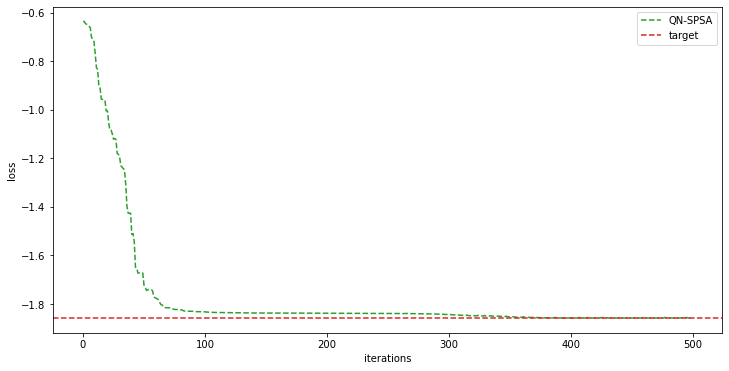

In [56]:
H2_fermionic_hamiltonian, H2_num_particles, H2_num_spin_orbitals, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
                  solve_ground_state(H2_info_dict, mapper ="Parity", two_qubit_reduction=True, z2symmetry_reduction=None,
                  loss=qnspsa_loss, label='QN-SPSA', target=-1.857274810366,
                  name_solver='Two-Local circuit and the QN-SPSA optimizer', solver=vqe_tl_QNSPSA_solver)

Figure 5.9 – Ground-state of the $\text{H}_{2}$ molecule with VQE using the Two-Local circuit and QN-SPSA

Figure 5.10 – Plot of the loss function of the VQE using the Two-Local circuit and QN-SPSA for the $\text{H}_{2}$ molecule

### Computing the BOPES

Fermionic Hamiltonian operator
Fermionic Operator
number spin orbitals=4, number terms=36
  0.33785507740175813 * ( +_0 +_0 -_0 -_0 )
+ 0.0904655998921157 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211564 * ( +_0 +_1 -_0 -_1 )
+ 0.3322908651276484 * ( +_0 +_1 -_1 -_0 )
+ 0.33785507740175813 * ( +_0 +_2 -_2 -_0 )
+ 0.0904655998921157 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211564 * ( +_0 +_3 -_2 -_1 )
+ 0.3322908651276484 * ( +_0 +_3 -_3 -_0 )
+ 0.33229086512764827 * ( +_1 +_0 -_0 -_1 )
+ 0.09046559989211572 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211564 * ( +_1 +_1 -_0 -_0 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.33229086512764827 * ( +_1 +_2 -_2 -_1 )
+ 0.09046559989211572 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211564 * ( +_1 +_3 -_2 -_0 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.33785507740175813 * ( +_2 +_0 -_0 -_2 )
+ 0.0904655998921157 * ( +_2 +_0 -_1 -_3 )
+ 0.09046559989211564 * ( +_2 +_1 -_0 -_3 )
+ 0.3322908651276484 * ( +_2 +_1 -_1 -_2 )
...
Number of particles: (1, 1)
Numb

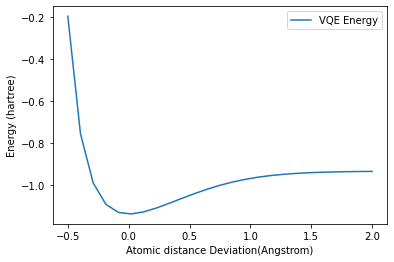

In [57]:
perturbation_steps = np.linspace(-0.5, 2, 25) # 25 equally spaced points from -0.2 to 4, inclusive.
H2_s_fermionic_hamiltonian, H2_s_num_particles, H2_s_num_spin_orbitals, H2_s_qubit_op, H2_s_qubit_converter, H2_s_ground_state = \
                  solve_ground_state(H2_info_dict, mapper ="Parity",
                   two_qubit_reduction=True, z2symmetry_reduction=None, 
                   name_solver = 'NumPy exact solver', solver = numpy_solver,
                   plot_bopes = True, perturbation_steps=perturbation_steps)

Figure 5.12 – Plot of the BOPES of the hydrogen molecule

## 5.2.2. Lithium hydride molecule

In [58]:
LiH_atoms = ["Li", "H"]
LiH_coords = [(0.0, 0.0, 0.0), (0.0, 0.0, 1.5474)]
LiH_charge = 0
LiH_multiplicity = 1
LiH_atom_pair=(1,0)
LiH_info_dict={'atoms':LiH_atoms, 'coords':LiH_coords, 'charge':LiH_charge, 'multiplicity':LiH_multiplicity, 'atom_pair':LiH_atom_pair}

LiH_moleculeinfo = MoleculeInfo(LiH_atoms, LiH_coords, charge=LiH_charge, multiplicity=LiH_multiplicity)

### Solving for the Ground-state

In [59]:
LiH_fermionic_hamiltonian, LiH_num_particles, LiH_num_spin_orbitals, LiH_qubit_op, LiH_qubit_converter, LiH_ground_state = \
                  solve_ground_state(LiH_info_dict, mapper="Parity",
                  freeze_core=FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3]),
                  two_qubit_reduction=True, z2symmetry_reduction="auto", 
                  name_solver='NumPy exact solver', solver=numpy_solver)

Fermionic Hamiltonian operator
Fermionic Operator
number spin orbitals=6, number terms=342
  0.2454848810509071 * ( +_0 +_0 -_0 -_0 )
+ -0.02385105856895492 * ( +_0 +_0 -_0 -_1 )
+ 0.06479059463973212 * ( +_0 +_0 -_0 -_2 )
+ -0.023851058568954905 * ( +_0 +_0 -_1 -_0 )
+ 0.0062789647509914025 * ( +_0 +_0 -_1 -_1 )
+ -0.016998316939607787 * ( +_0 +_0 -_1 -_2 )
+ 0.06479059463973216 * ( +_0 +_0 -_2 -_0 )
+ -0.016998316939607794 * ( +_0 +_0 -_2 -_1 )
+ 0.0616921939265509 * ( +_0 +_0 -_2 -_2 )
+ -0.02385105856895491 * ( +_0 +_1 -_0 -_0 )
+ 0.006278964750991413 * ( +_0 +_1 -_0 -_1 )
+ -0.0169983169396078 * ( +_0 +_1 -_0 -_2 )
+ 0.11257756334433247 * ( +_0 +_1 -_1 -_0 )
+ 0.0033949299247708867 * ( +_0 +_1 -_1 -_1 )
+ -0.0054745012246734765 * ( +_0 +_1 -_1 -_2 )
+ -0.025558666066023618 * ( +_0 +_1 -_2 -_0 )
+ 0.004443221616282542 * ( +_0 +_1 -_2 -_1 )
+ -0.01571800653178825 * ( +_0 +_1 -_2 -_2 )
+ 0.06479059463973202 * ( +_0 +_2 -_0 -_0 )
+ -0.01699831693960778 * ( +_0 +_2 -_0 -_1 )
...
Number

Figure 5.13 – Ground-state of the $\text{LiH}$ molecule with PySCF RHF, PyQMC Monte Carlo and QPE

Figure 5.14. Ground-state of the $\text{LiH}$ molecule with VQE using the NumPy minimum eigensolver

In [60]:
LiH_fermionic_hamiltonian, LiH_num_particles, LiH_num_spin_orbitals, LiH_qubit_op, LiH_qubit_converter, LiH_ground_state = \
                  solve_ground_state(LiH_info_dict, mapper="Parity",
                  freeze_core=FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3]),
                  two_qubit_reduction=True, z2symmetry_reduction="auto", 
                  name_solver = 'Heuristic ansatz, the Two-Local circuit with SLSQP', solver = vqe_tl_solver)

Fermionic Hamiltonian operator
Fermionic Operator
number spin orbitals=6, number terms=342
  0.24548488105088562 * ( +_0 +_0 -_0 -_0 )
+ -0.023851058568999068 * ( +_0 +_0 -_0 -_1 )
+ 0.06479059463971548 * ( +_0 +_0 -_0 -_2 )
+ -0.02385105856899905 * ( +_0 +_0 -_1 -_0 )
+ 0.006278964751011005 * ( +_0 +_0 -_1 -_1 )
+ -0.016998316939632278 * ( +_0 +_0 -_1 -_2 )
+ 0.06479059463971551 * ( +_0 +_0 -_2 -_0 )
+ -0.016998316939632285 * ( +_0 +_0 -_2 -_1 )
+ 0.06169219392653935 * ( +_0 +_0 -_2 -_2 )
+ -0.023851058568999058 * ( +_0 +_1 -_0 -_0 )
+ 0.006278964751011012 * ( +_0 +_1 -_0 -_1 )
+ -0.01699831693963227 * ( +_0 +_1 -_0 -_2 )
+ 0.11257756334435215 * ( +_0 +_1 -_1 -_0 )
+ 0.003394929924785611 * ( +_0 +_1 -_1 -_1 )
+ -0.00547450122465466 * ( +_0 +_1 -_1 -_2 )
+ -0.02555866606604778 * ( +_0 +_1 -_2 -_0 )
+ 0.004443221616304373 * ( +_0 +_1 -_2 -_1 )
+ -0.015718006531806716 * ( +_0 +_1 -_2 -_2 )
+ 0.06479059463971545 * ( +_0 +_2 -_0 -_0 )
+ -0.016998316939632274 * ( +_0 +_2 -_0 -_1 )
...
Numbe

Figure 5.15 – Ground-state of the $\text{LiH}$ molecule with VQE using the Two-Local circuit and SLSQP

In [61]:
#https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.QNSPSA.html?highlight=qnspsa#qiskit.algorithms.optimizers.QNSPSA
qnspsa_loss = []
ansatz = tl_circuit
sampler = Sampler()
fidelity = QNSPSA.get_fidelity(ansatz, sampler)
qnspsa = QNSPSA(fidelity, maxiter=500, learning_rate=0.01, perturbation=0.7, callback=qnspsa_callback)

In [62]:
vqe_tl_QNSPSA_solver = VQE(estimator, tl_circuit, optimizer=qnspsa)

Fermionic Hamiltonian operator
Fermionic Operator
number spin orbitals=6, number terms=342
  0.2454848810508779 * ( +_0 +_0 -_0 -_0 )
+ -0.02385105856901456 * ( +_0 +_0 -_0 -_1 )
+ 0.0647905946397095 * ( +_0 +_0 -_0 -_2 )
+ -0.023851058569014566 * ( +_0 +_0 -_1 -_0 )
+ 0.006278964751017916 * ( +_0 +_0 -_1 -_1 )
+ -0.016998316939641024 * ( +_0 +_0 -_1 -_2 )
+ 0.06479059463970951 * ( +_0 +_0 -_2 -_0 )
+ -0.016998316939640996 * ( +_0 +_0 -_2 -_1 )
+ 0.061692193926535216 * ( +_0 +_0 -_2 -_2 )
+ -0.02385105856901457 * ( +_0 +_1 -_0 -_0 )
+ 0.006278964751017924 * ( +_0 +_1 -_0 -_1 )
+ -0.016998316939641014 * ( +_0 +_1 -_0 -_2 )
+ 0.11257756334435942 * ( +_0 +_1 -_1 -_0 )
+ 0.0033949299247905042 * ( +_0 +_1 -_1 -_1 )
+ -0.0054745012246479935 * ( +_0 +_1 -_1 -_2 )
+ -0.025558666066056814 * ( +_0 +_1 -_2 -_0 )
+ 0.004443221616312078 * ( +_0 +_1 -_2 -_1 )
+ -0.01571800653181351 * ( +_0 +_1 -_2 -_2 )
+ 0.06479059463970947 * ( +_0 +_2 -_0 -_0 )
+ -0.01699831693964099 * ( +_0 +_2 -_0 -_1 )
...
Numb

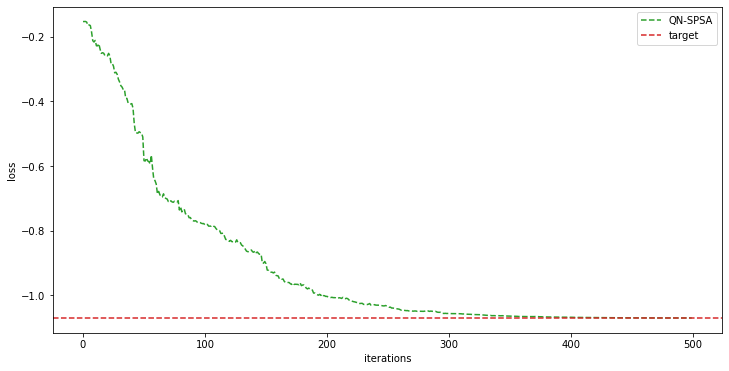

In [63]:
LiH_fermionic_hamiltonian, LiH_num_particles, LiH_num_spin_orbitals, LiH_qubit_op, LiH_qubit_converter, LiH_ground_state = \
                  solve_ground_state(LiH_info_dict, mapper="Parity",
                  freeze_core=FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3]),
                  two_qubit_reduction=True, z2symmetry_reduction="auto", loss=qnspsa_loss, label='QN-SPSA', target=-1.0703584,
                  name_solver='Two-Local circuit and the QN-SPSA optimizer', solver=vqe_tl_QNSPSA_solver)

Figure 5.16 – Ground-state of the $\text{LiH}$ molecule with VQE using the Two-Local circuit and QN-SPSA

Figure 5.17 – Loss function of the VQE using the Two-Local circuit and QN-SPSA for the $\text{LiH}$ molecule

Figure 5.18 – Table summarizing the calculations of the ground state energy obtained with the $\text{LiH}$ molecule

### Computing the Born-Oppenheimer Potential Energy Surface (BOPES)

Fermionic Hamiltonian operator
Fermionic Operator
number spin orbitals=6, number terms=342
  0.2454848810508554 * ( +_0 +_0 -_0 -_0 )
+ -0.023851058569061917 * ( +_0 +_0 -_0 -_1 )
+ 0.06479059463969192 * ( +_0 +_0 -_0 -_2 )
+ -0.02385105856906189 * ( +_0 +_0 -_1 -_0 )
+ 0.006278964751038882 * ( +_0 +_0 -_1 -_1 )
+ -0.01699831693966717 * ( +_0 +_0 -_1 -_2 )
+ 0.06479059463969195 * ( +_0 +_0 -_2 -_0 )
+ -0.016998316939667194 * ( +_0 +_0 -_2 -_1 )
+ 0.06169219392652288 * ( +_0 +_0 -_2 -_2 )
+ -0.0238510585690619 * ( +_0 +_1 -_0 -_0 )
+ 0.006278964751038881 * ( +_0 +_1 -_0 -_1 )
+ -0.016998316939667166 * ( +_0 +_1 -_0 -_2 )
+ 0.1125775633443804 * ( +_0 +_1 -_1 -_0 )
+ 0.003394929924806344 * ( +_0 +_1 -_1 -_1 )
+ -0.005474501224627862 * ( +_0 +_1 -_1 -_2 )
+ -0.025558666066082494 * ( +_0 +_1 -_2 -_0 )
+ 0.004443221616335391 * ( +_0 +_1 -_2 -_1 )
+ -0.015718006531833115 * ( +_0 +_1 -_2 -_2 )
+ 0.06479059463969188 * ( +_0 +_2 -_0 -_0 )
+ -0.016998316939667177 * ( +_0 +_2 -_0 -_1 )
...
Number 

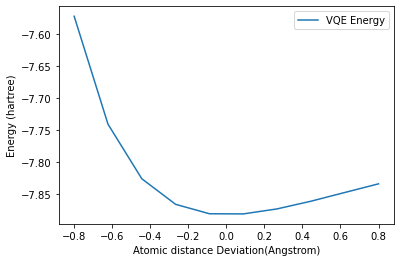

In [64]:
perturbation_steps = np.linspace(-0.8, 0.8, 10) # 10 equally spaced points from -0.8 to 0.8, inclusive.
LiH_s_fermionic_hamiltonian, LiH_s_num_particles, LiH_s_num_spin_orbitals, LiH_s_qubit_op, LiH_s_qubit_converter, LiH_s_ground_state = \
                  solve_ground_state(LiH_info_dict, mapper ="Parity",
                  freeze_core=FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3]),
                   two_qubit_reduction=True, z2symmetry_reduction="auto", 
                   name_solver='NumPy exact solver', solver=numpy_solver,
                   plot_bopes=True, perturbation_steps=perturbation_steps)

Figure 5.19 – Plot of the Born-Oppenheimer Potential Energy Surface (BOPES) of the $\text{LiH}$ molecule

## 5.2.3. Macro molecule

In [65]:
macro_ASE = Atoms('ONCHHHC', [(1.1280, 0.2091, 0.0000), 
                          (-1.1878, 0.1791, 0.0000), 
                          (0.0598, -0.3882, 0.0000),
                          (-1.3085, 1.1864, 0.0001),
                          (-2.0305, -0.3861, -0.0001),
                          (-0.0014, -1.4883, -0.0001),
                          (-0.1805, 1.3955, 0.0000)])

In [66]:
view(macro_ASE, viewer='x3d')

Figure 5.20 – Macro molecule

In [67]:
M_atoms = ["O","N","C","H","H","H","C"]
M_coords = [(1.1280, 0.2091, 0.0000), 
                    (-1.1878, 0.1791, 0.0000),
                    (0.0598, -0.3882, 0.0000),
                    (-1.3085, 1.1864, 0.0001),
                    (-2.0305, -0.3861, -0.0001),
                    (-0.0014, -1.4883, -0.0001),
                    (-0.1805, 1.3955, 0.0000)]
M_charge = 0
M_multiplicity = 1
M_atom_pair=(6, 1)
M_info_dict={'atoms':M_atoms, 'coords':M_coords, 'charge':M_charge, 'multiplicity':M_multiplicity, 'atom_pair':M_atom_pair}

macromoleculeinfo = MoleculeInfo(M_atoms, M_coords, charge=M_charge, multiplicity=M_multiplicity)

### Solving for the Ground-state

In [68]:
print("Macro molecule")
print("Using the ParityMapper with two_qubit_reduction=True to eliminate two qubits")
print("Parameters ActiveSpaceTransformer(num_electrons=2, num_molecular_orbitals=2)")
print("Setting z2symmetry_reduction=\"auto\"")

Macro molecule
Using the ParityMapper with two_qubit_reduction=True to eliminate two qubits
Parameters ActiveSpaceTransformer(num_electrons=2, num_molecular_orbitals=2)
Setting z2symmetry_reduction="auto"


In [69]:
macro_fermionic_hamiltonian, macro_particle_num_particles, macro_particle_num_spin_orbitals, macro_qubit_op, macro_qubit_converter, macro_ground_state = \
                  solve_ground_state(M_info_dict, mapper="Parity",
                  num_electrons=2, num_spatial_orbitals=2,
                  two_qubit_reduction=True, z2symmetry_reduction="auto", 
                  name_solver='NumPy exact solver', solver=numpy_solver, pyqmc=False)

Fermionic Hamiltonian operator
Fermionic Operator
number spin orbitals=4, number terms=72
  0.3059180961453185 * ( +_0 +_0 -_0 -_0 )
+ 0.02553837251977948 * ( +_0 +_0 -_0 -_1 )
+ 0.025538372519779452 * ( +_0 +_0 -_1 -_0 )
+ 0.013459756138882619 * ( +_0 +_0 -_1 -_1 )
+ 0.02553837251977946 * ( +_0 +_1 -_0 -_0 )
+ 0.013459756138882617 * ( +_0 +_1 -_0 -_1 )
+ 0.15143562248740172 * ( +_0 +_1 -_1 -_0 )
+ -0.024634277834934864 * ( +_0 +_1 -_1 -_1 )
+ 0.3059180961453185 * ( +_0 +_2 -_2 -_0 )
+ 0.02553837251977946 * ( +_0 +_2 -_2 -_1 )
+ 0.025538372519779487 * ( +_0 +_2 -_3 -_0 )
+ 0.013459756138882617 * ( +_0 +_2 -_3 -_1 )
+ 0.02553837251977948 * ( +_0 +_3 -_2 -_0 )
+ 0.013459756138882617 * ( +_0 +_3 -_2 -_1 )
+ 0.15143562248740183 * ( +_0 +_3 -_3 -_0 )
+ -0.02463427783493484 * ( +_0 +_3 -_3 -_1 )
+ 0.025538372519779487 * ( +_1 +_0 -_0 -_0 )
+ 0.15143562248740183 * ( +_1 +_0 -_0 -_1 )
+ 0.013459756138882619 * ( +_1 +_0 -_1 -_0 )
+ -0.02463427783493487 * ( +_1 +_0 -_1 -_1 )
...
Number of partic

Figure 5.21 – First 20 terms of the fermionic Hamiltonian operator of the macro molecule

Figure 5.22 – Qubit Hamiltonian operator of the outermost two electrons of the macro molecule

Figure 5.23 – Total and electronic ground state energy of the macro molecule by PySCF and QPE respectively

Figure 5.24 – Ground state of macro molecule using the NumPy exact minimum eigensolver

### Computing the BOPES

Fermionic Hamiltonian operator
Fermionic Operator
number spin orbitals=4, number terms=72
  0.30591809614531845 * ( +_0 +_0 -_0 -_0 )
+ 0.025538372519779858 * ( +_0 +_0 -_0 -_1 )
+ 0.025538372519779837 * ( +_0 +_0 -_1 -_0 )
+ 0.013459756138882704 * ( +_0 +_0 -_1 -_1 )
+ 0.025538372519779834 * ( +_0 +_1 -_0 -_0 )
+ 0.013459756138882705 * ( +_0 +_1 -_0 -_1 )
+ 0.1514356224874016 * ( +_0 +_1 -_1 -_0 )
+ -0.024634277834934836 * ( +_0 +_1 -_1 -_1 )
+ 0.30591809614531845 * ( +_0 +_2 -_2 -_0 )
+ 0.025538372519779834 * ( +_0 +_2 -_2 -_1 )
+ 0.025538372519779855 * ( +_0 +_2 -_3 -_0 )
+ 0.013459756138882697 * ( +_0 +_2 -_3 -_1 )
+ 0.025538372519779858 * ( +_0 +_3 -_2 -_0 )
+ 0.013459756138882705 * ( +_0 +_3 -_2 -_1 )
+ 0.15143562248740167 * ( +_0 +_3 -_3 -_0 )
+ -0.024634277834934833 * ( +_0 +_3 -_3 -_1 )
+ 0.025538372519779855 * ( +_1 +_0 -_0 -_0 )
+ 0.15143562248740167 * ( +_1 +_0 -_0 -_1 )
+ 0.0134597561388827 * ( +_1 +_0 -_1 -_0 )
+ -0.024634277834934857 * ( +_1 +_0 -_1 -_1 )
...
Number of p

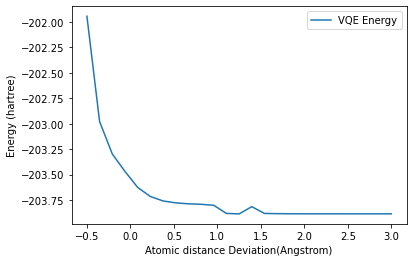

In [70]:
perturbation_steps = np.linspace(-0.5, 3, 25) # 25 equally spaced points from -0.5 to 3, inclusive.
macro_fermionic_hamiltonian, macro_particle_num_particles, macro_particle_num_spin_orbitals, macro_qubit_op, macro_qubit_converter, macro_ground_state = \
                  solve_ground_state(M_info_dict, mapper="Parity",
                  num_electrons=2, num_spatial_orbitals=2,
                  two_qubit_reduction=True, z2symmetry_reduction="auto",  
                  name_solver='NumPy exact solver', solver=numpy_solver, pyqmc=False,
                  plot_bopes=True, perturbation_steps=perturbation_steps)

Figure 5.25 – Plot of the Born-Oppenheimer Potential Energy Surface (BOPES) of the macro molecule

# Summary

# Questions

1.   Does the variational theorem apply to excited states?


In [71]:
#@title Enter your answer Yes, No or ? for a solution, then execute cell.
answer = "" #@param {type:"string"}
solution = "Yes"
if answer == solution:
  print("Correct")
elif answer == '?':
  print(solution)
else:
  print("Incorrect, please try again")

Incorrect, please try again


2. True or False: The Metropolis-Hastings method is a way to approximate integration over spatial coordinates.

In [72]:
#@title Enter your answer True, False or ? for a solution, then execute cell.
answer = "" #@param {type:"string"}
solution = "True"
if answer == solution:
  print("Correct")
elif answer == '?':
  print(solution)
else:
  print("Incorrect, please try again")

Incorrect, please try again


3. True or False: VQE is only a quantum computing algorithm and does not require the use of classical computing.

In [73]:
#@title Enter your answer True, False or ? for a solution, then execute cell.
answer = "" #@param {type:"string"}
solution = "False"
if answer == solution:
  print("Correct")
elif answer == '?':
  print(solution)
else:
  print("Incorrect, please try again")

Incorrect, please try again


In [74]:
# Display Qiskit Software and System information
import qiskit.tools.jupyter
%qiskit_version_table